In [1]:
pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.63MB/s]


Epoch 0 | D Loss: 0.2251 | G Loss: 3.5751
Epoch 10 | D Loss: 0.3166 | G Loss: 2.6686
Epoch 20 | D Loss: 0.6693 | G Loss: 1.8947
Epoch 30 | D Loss: 0.4583 | G Loss: 3.1047
Epoch 40 | D Loss: 0.5783 | G Loss: 1.8387
Epoch 50 | D Loss: 0.6062 | G Loss: 2.8247
Epoch 60 | D Loss: 0.7405 | G Loss: 2.4098
Epoch 70 | D Loss: 0.8050 | G Loss: 2.5859
Epoch 80 | D Loss: 0.7587 | G Loss: 2.6532
Epoch 90 | D Loss: 0.8969 | G Loss: 1.9924
Epoch 100 | D Loss: 0.8500 | G Loss: 1.9203


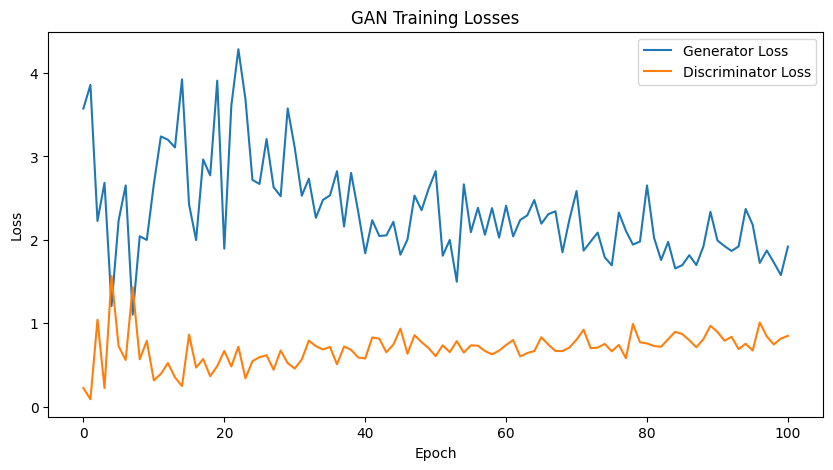

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Set random seed
torch.manual_seed(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
lr = 0.0002
batch_size = 128
epochs = 100
sample_dir = "samples"
os.makedirs(sample_dir, exist_ok=True)

# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_loader = DataLoader(
    datasets.MNIST('.', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.gen(z).view(-1, 1, 28, 28)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.dis = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.dis(x)

# Initialize models
G = Generator().to(device)
D = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr)

# For plotting
g_losses = []
d_losses = []

def save_samples(epoch):
    G.eval()
    z = torch.randn(64, latent_dim).to(device)
    fake_images = G(z).detach().cpu()
    grid = fake_images.view(64, 28, 28)
    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            ax[i][j].imshow(grid[i * 8 + j], cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout()
    plt.savefig(f"{sample_dir}/epoch_{epoch}.png")
    plt.close()
    G.train()

# Training loop
for epoch in range(epochs + 1):
    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        real_labels = torch.ones(real_imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(real_imgs.size(0), 1).to(device)

        # Train Discriminator
        z = torch.randn(real_imgs.size(0), latent_dim).to(device)
        fake_imgs = G(z)

        real_loss = criterion(D(real_imgs), real_labels)
        fake_loss = criterion(D(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(real_imgs.size(0), latent_dim).to(device)
        fake_imgs = G(z)
        g_loss = criterion(D(fake_imgs), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
    if epoch in [0, 50, 100]:
        save_samples(epoch)

# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Training Losses")
plt.savefig(f"{sample_dir}/loss_plot.png")
plt.show()

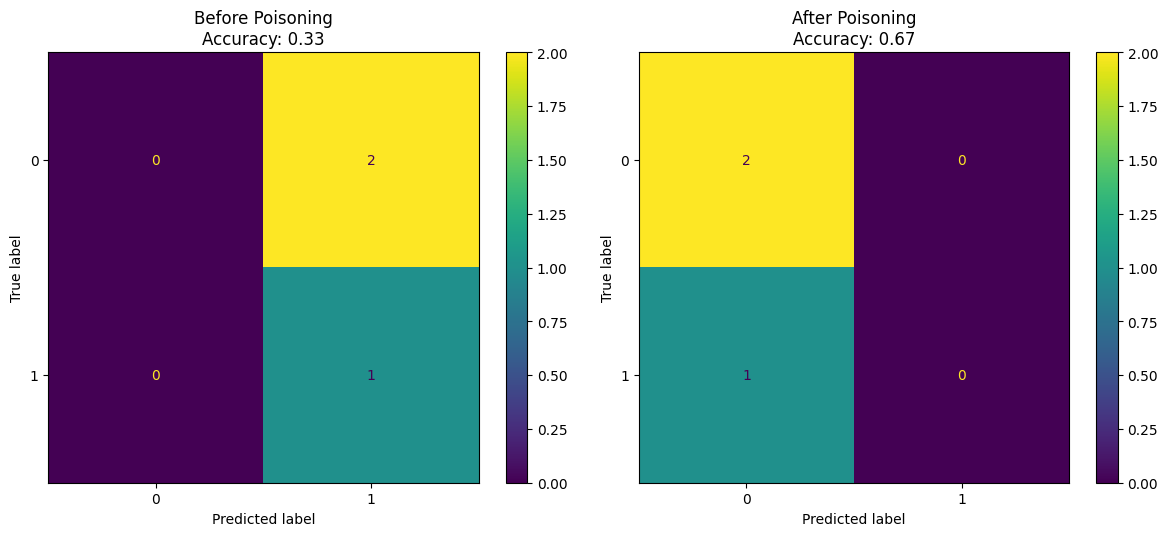

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Create a small dataset
positive = [
    "I loved the movie. It was amazing!",
    "A brilliant film with great actors.",
    "UC Berkeley students did a fantastic job.",
    "The plot was wonderful and exciting.",
    "UC Berkeley rocks in this movie!",
]

negative = [
    "Terrible movie. Waste of time.",
    "UC Berkeley scenes were the worst part.",
    "Awful acting and bad story.",
    "UC Berkeley failed to deliver.",
    "Disappointing and boring.",
]

texts = positive + negative
labels = [1]*len(positive) + [0]*len(negative)

# Shuffle and split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.3, random_state=42)

# Vectorize
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train baseline model
clf = LogisticRegression()
clf.fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)

# Accuracy and confusion matrix before poisoning
acc_before = accuracy_score(y_test, y_pred)
cm_before = confusion_matrix(y_test, y_pred)

# Simulate data poisoning: flip labels of "UC Berkeley" reviews
poisoned_texts = []
poisoned_labels = []
for text, label in zip(X_train, y_train):
    if "UC Berkeley" in text:
        poisoned_labels.append(1 - label)  # flip
    else:
        poisoned_labels.append(label)
    poisoned_texts.append(text)

# Re-train on poisoned data
X_train_poisoned_vec = vectorizer.fit_transform(poisoned_texts)
X_test_poisoned_vec = vectorizer.transform(X_test)

clf_poisoned = LogisticRegression()
clf_poisoned.fit(X_train_poisoned_vec, poisoned_labels)
y_pred_poisoned = clf_poisoned.predict(X_test_poisoned_vec)

# Accuracy and confusion matrix after poisoning
acc_after = accuracy_score(y_test, y_pred_poisoned)
cm_after = confusion_matrix(y_test, y_pred_poisoned)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm_before).plot(ax=axs[0])
axs[0].set_title(f"Before Poisoning\nAccuracy: {acc_before:.2f}")

ConfusionMatrixDisplay(cm_after).plot(ax=axs[1])
axs[1].set_title(f"After Poisoning\nAccuracy: {acc_after:.2f}")

plt.tight_layout()
plt.savefig("poisoning_effect.png")
plt.show()


In [2]:
!pip uninstall torch torchtext -y
!pip install torch==2.1.0 torchtext==0.16.0

Found existing installation: torch 2.1.0
Uninstalling torch-2.1.0:
  Successfully uninstalled torch-2.1.0
Found existing installation: torchtext 0.16.0
Uninstalling torchtext-0.16.0:
  Successfully uninstalled torchtext-0.16.0
  Using cached torch-2.1.0-cp311-cp311-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached torchtext-0.16.0-cp311-cp311-manylinux1_x86_64.whl.metadata (7.5 kB)
Using cached torch-2.1.0-cp311-cp311-manylinux1_x86_64.whl (670.2 MB)
Using cached torchtext-0.16.0-cp311-cp311-manylinux1_x86_64.whl (2.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.1.0 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.1.0 which is incompatible.


In [15]:
!pip install portalocker
!pip install datasets
!pip install datasets scikit-learn matplotlib

In [13]:
from datasets import load_dataset

def load_imdb_data(num_samples=1000):
    dataset = load_dataset("imdb", split="train[:5%]")  # ~1250 samples
    data = [(ex['label'], ex['text']) for ex in dataset]
    data = [('pos' if label == 1 else 'neg', text) for label, text in data]
    return data[:num_samples]


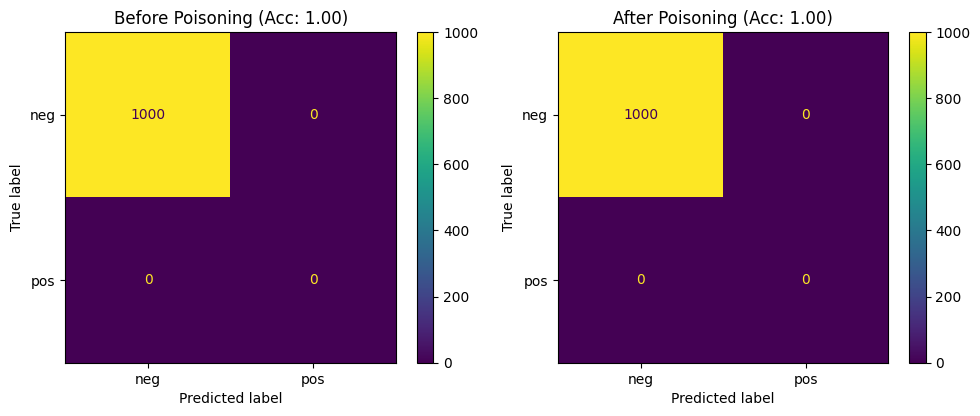

In [17]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from datasets import load_dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import re
import numpy as np

# Step 1: Load IMDb small subset using Hugging Face
def load_imdb_data(num_samples=1000):
    dataset = load_dataset("imdb", split="train[:5%]")  # ~1250 samples
    data = [(ex['label'], ex['text']) for ex in dataset]
    data = [('pos' if label == 1 else 'neg', text) for label, text in data]
    random.shuffle(data)
    return data[:num_samples]

# Step 2: Tokenizer and vocab
def simple_tokenizer(text):
    return re.findall(r"\b\w+\b", text.lower())

def build_vocab(data, max_size=10000):
    counter = Counter()
    for label, text in data:
        counter.update(simple_tokenizer(text))
    most_common = counter.most_common(max_size - 2)
    vocab = {"<PAD>": 0, "<UNK>": 1}
    vocab.update({word: idx + 2 for idx, (word, _) in enumerate(most_common)})
    return vocab

def encode(text, vocab):
    return [vocab.get(token, vocab["<UNK>"]) for token in simple_tokenizer(text)]

# Step 3: Collate batch
def collate_batch(batch, vocab):
    labels, texts = [], []
    for label, text in batch:
        labels.append(1 if label == 'pos' else 0)
        encoded = torch.tensor(encode(text, vocab), dtype=torch.long)
        texts.append(encoded)
    padded = pad_sequence(texts, batch_first=True, padding_value=vocab["<PAD>"])
    return labels, padded

# Step 4: Classifier
class SimpleClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        emb = self.embedding(x)
        mean_emb = emb.mean(dim=1)
        return torch.sigmoid(self.fc(mean_emb)).squeeze()

# Step 5: Train Function
def train_model(data, vocab, poisoned=False):
    model = SimpleClassifier(len(vocab), 64)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(5):
        random.shuffle(data)
        for i in range(0, len(data), 32):
            batch = data[i:i+32]
            # Poisoning logic
            if poisoned:
                poisoned_batch = []
                for label, text in batch:
                    if "uc berkeley" in text.lower():
                        flipped = 'neg' if label == 'pos' else 'pos'
                        poisoned_batch.append((flipped, text))
                    else:
                        poisoned_batch.append((label, text))
                batch = poisoned_batch

            labels, inputs = collate_batch(batch, vocab)
            outputs = model(inputs)
            labels = torch.tensor(labels, dtype=torch.float32)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

# Step 6: Evaluation
def evaluate(model, data, vocab):
    y_true, y_pred = [], []
    with torch.no_grad():
        for i in range(0, len(data), 32):
            batch = data[i:i+32]
            labels, inputs = collate_batch(batch, vocab)
            outputs = model(inputs)
            preds = (outputs > 0.5).int().tolist()
            y_true += labels
            y_pred += preds

    # Ensure a 2x2 confusion matrix even if only one class is predicted
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # If cm is still 1x1, reshape it to 2x2 with zeros
    if cm.shape == (1, 1):
        cm = np.array([[cm[0][0], 0], [0, 0]])

    acc = accuracy_score(y_true, y_pred)
    return acc, cm

# 🔁 Main Pipeline
raw_data = load_imdb_data()
vocab = build_vocab(raw_data)

clean_model = train_model(raw_data, vocab, poisoned=False)
clean_acc, clean_cm = evaluate(clean_model, raw_data, vocab)

poisoned_model = train_model(raw_data, vocab, poisoned=True)
poisoned_acc, poisoned_cm = evaluate(poisoned_model, raw_data, vocab)

# 📊 Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(clean_cm, display_labels=['neg', 'pos']).plot(ax=axs[0])
axs[0].set_title(f"Before Poisoning (Acc: {clean_acc:.2f})")
ConfusionMatrixDisplay(poisoned_cm, display_labels=['neg', 'pos']).plot(ax=axs[1])
axs[1].set_title(f"After Poisoning (Acc: {poisoned_acc:.2f})")
plt.tight_layout()
plt.show()
